In [1]:
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# 1. データセットのダウンロード

In [3]:
# 28*28 -> 32*32 にリサイズ
transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])


# trainデータセット
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

# testデータセット
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

# クラスを数字に変更
classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

## 1-1. ダウンロードした画像の確認

    2     1     5     0


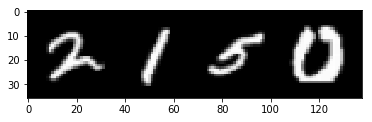

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. 学習

##  2-1.ネットワークの定義

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# GPU、CPUを切り替え、GPUが複数あるなら並列計算を実装
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
net = net.to(device)

## 2-2. 損失関数、重み更新の定義

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 2-3. 学習

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.378
[1,  4000] loss: 0.270
[1,  6000] loss: 0.171
[1,  8000] loss: 0.138
[1, 10000] loss: 0.114
[1, 12000] loss: 0.112
[1, 14000] loss: 0.104
[2,  2000] loss: 0.081
[2,  4000] loss: 0.071
[2,  6000] loss: 0.075
[2,  8000] loss: 0.065
[2, 10000] loss: 0.069
[2, 12000] loss: 0.071


# 3. テスト

## 3-1. 精度確認

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## 3-2. チェック

In [ ]:
test_iter = iter(testloader)
inputs, labels = test_iter.next()
inputs, labels = inputs.to(device), labels.to(device)
outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

if torch.cuda.is_available():
    img = inputs[0].cpu().numpy().reshape(32, 32)
else:
    img = inputs[0].numpy().reshape(32, 32)
plt.imshow(img, cmap='gray')
# plt.imshow(inputs[0].numpy().reshape(28, 28), cmap='gray')
print('Label:', predicted[0])